<h1>Jamaica Stock Exchange Analysis  </h1>
<p> Basic anslysis data sciences information </p>
<ul> 
<li> Calculate Simple Rate of Return </li>
<li> Stock Risk calculation
<li> Adjustment of split stocks 2015-2018</li>
<li> Calculate Rate of Return for Portfolio </li>
<li> Calculate Risk Variance for Portfolio </li>
<li> Time vs Price regression on stocks </li>
<li> Markowitz Portfolio effeciency </li>
</ul>
<p><b> #Todo </b><i>Adjust for dividends to stock analysis</i></p>
<p><b> #Todo </b><i>Predictive Model</i></p>

<p>&copy; 2018 Romayne Whyte (Ijasoft) <p>



In [1]:
import pandas as pd
import numpy as np
import os
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy import linalg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

<h2>Pulling Informtion from CSV Files</h2>

In [2]:
#Pull the valid stock information
slist = []
folder = 'project'
filelist = os.listdir('c:/'+folder+'/stockcsv/')
for filename in filelist:
    slist.append(pd.read_csv('c:/'+folder+'/stockcsv/'+filename))
    
frame = pd.concat(slist, axis = 0, ignore_index = True)
frame = frame.sort_values(by='Date')
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close Price,Price Change,Closing Bid,Closing Ask
164623,SOS,1/10/2018,6.00,3.5,NaN,NaN,6188.0,4.8,4.8,4.8,4.8,0.0,4.80,4.90
164556,EPLY,1/10/2018,13.00,10.0,0.3716,NaN,5000.0,12.0,12.0,12.0,12.0,0.0,10.00,11.00
164557,EPLY8.25,1/10/2018,6.10,5.5,NaN,NaN,0.0,0.0,0.0,5.5,5.5,0.0,5.45,5.50
164558,EPLY9.5,1/10/2018,7.25,6.0,0.6201,NaN,100.0,7.2,7.2,7.2,7.2,0.0,0.00,7.20
164559,EPLYSTP,1/10/2018,6.85,6.0,0.7205,NaN,0.0,0.0,0.0,6.0,6.0,0.0,6.02,6.55


In [3]:
#Pull the list of delisted to remove from stock frame
framevalid = pd.read_csv('c:/'+folder+'/stockdelist/stockvalid.csv')
framevalid = framevalid.rename(columns={'Instrument Code': 'Symbol'})
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
1,138 STUDENT LIVING JAMAICA LIMITED VARIABLE PR...,138SLVR,JMD,OTHER,PREFERENCE,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website


In [4]:
slist = []
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (1).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (2).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (3).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (4).csv'))
df_info = pd.concat(slist, axis = 0, ignore_index = True)
df_info.head()

,Symbol,Record Date,Action,Dividend Amount,Ex-Date,Payment Date
0,EPLY,12/4/2018,NaN,0.037200,12/3/2018,12/18/2018
1,1834,12/3/2018,NaN,0.100000,11/30/2018,12/19/2018
2,JMMBGL7.50,11/30/2018,NaN,0.004635,11/29/2018,12/14/2018
3,JMMBGL7.25,11/30/2018,NaN,0.006953,11/29/2018,12/14/2018
4,SIL,11/27/2018,Stock Split,5.000000,11/26/2018,NaN


In [5]:
#Pull the valid stock Indicies

slist = []
filelist = os.listdir('c:/'+folder+'/stockindicies/')
for filename in filelist:
    slist.append(pd.read_csv('c:/'+folder+'/stockindicies/'+filename))
    
stkindices_frame = pd.concat(slist, axis = 0, ignore_index = True)
stkindices_frame = stkindices_frame.dropna(axis=0)
stkindices_frame.head()

,Index,Date,Value,Change ($),Change (%),Volume Traded
0,Combined-Index,2017-01-03,206552.15,1592.05,0.78,7228125.0
1,JSE-Index,2017-01-03,194129.75,1853.11,0.96,6933316.0
2,All-Jamaican,2017-01-03,212211.90,2072.41,0.99,6555316.0
3,JSE-Select,2017-01-03,6493.43,89.66,1.40,4924157.0
5,JSE-Junior,2017-01-03,2581.42,-12.29,-0.47,294809.0


<h2>Time for Clean Up</h2>

In [6]:
stkindices_frame = stkindices_frame.drop(['Change ($)','Change (%)','Volume Traded'],axis=1)
stkindices_frame['Date'] = pd.to_datetime(stkindices_frame['Date'])

In [7]:
#split the indicies by index
gp_index = stkindices_frame.groupby("Index")
stk_indicies_list = [gp_index.get_group(x) for x in gp_index.groups]

df_ind_data = pd.DataFrame()
for idx, index in enumerate(stk_indicies_list):
    stk_indicies_list[idx] = stk_indicies_list[idx].set_index('Date')
    df_ind_data[index['Index'].iloc[0]] = stk_indicies_list[idx]['Value']

df_ind_data = df_ind_data.sort_index(axis=0)
df_ind_data.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2010-01-05,71100.38,NaN,962.92,83386.18,NaN,1902.95,NaN
2010-01-06,70733.92,NaN,962.92,83161.22,150.01,1885.31,NaN
2010-01-07,70335.37,NaN,960.42,82813.36,150.01,1864.57,NaN
2010-01-08,70504.66,NaN,960.42,82917.28,150.01,1870.74,NaN
2010-01-11,70268.72,NaN,960.42,82772.44,150.01,1862.06,NaN


In [8]:
frame = frame.rename(columns={'Close Price': 'Close'})
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close,Price Change,Closing Bid,Closing Ask
164623,SOS,1/10/2018,6.00,3.5,NaN,NaN,6188.0,4.8,4.8,4.8,4.8,0.0,4.80,4.90
164556,EPLY,1/10/2018,13.00,10.0,0.3716,NaN,5000.0,12.0,12.0,12.0,12.0,0.0,10.00,11.00
164557,EPLY8.25,1/10/2018,6.10,5.5,NaN,NaN,0.0,0.0,0.0,5.5,5.5,0.0,5.45,5.50
164558,EPLY9.5,1/10/2018,7.25,6.0,0.6201,NaN,100.0,7.2,7.2,7.2,7.2,0.0,0.00,7.20
164559,EPLYSTP,1/10/2018,6.85,6.0,0.7205,NaN,0.0,0.0,0.0,6.0,6.0,0.0,6.02,6.55


In [9]:
framevalid = framevalid[framevalid.Type == "ORDINARY"]
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website
6,CARIBBEAN CEMENT COMPANY LTD.,CCC,JMD,MANUFACTURING,ORDINARY,Website


In [10]:
#Remove unnecessary columns
frame = frame.drop(['52 Week High','52 Week Low','Current Year Div','Today High','Today Low','Last Traded','Price Change','Closing Bid','Closing Ask','Previous Year Div','Volume (non block)'],axis=1)
frame.head()

,Symbol,Date,Close
164623,SOS,1/10/2018,4.8
164556,EPLY,1/10/2018,12.0
164557,EPLY8.25,1/10/2018,5.5
164558,EPLY9.5,1/10/2018,7.2
164559,EPLYSTP,1/10/2018,6.0


In [11]:
#filter for only the valid stocks
frame = frame[frame["Symbol"].isin(framevalid["Symbol"].tolist())]
frame.head()

,Symbol,Date,Close
164623,SOS,1/10/2018,4.80
164556,EPLY,1/10/2018,12.00
164560,FOSRICH,1/10/2018,2.58
164561,GENAC,1/10/2018,2.95
164562,GK,1/10/2018,42.84


In [12]:

frame['Date'] = pd.to_datetime(frame['Date'])
frame.head()

,Symbol,Date,Close
164623,SOS,2018-01-10,4.80
164556,EPLY,2018-01-10,12.00
164560,FOSRICH,2018-01-10,2.58
164561,GENAC,2018-01-10,2.95
164562,GK,2018-01-10,42.84


In [13]:
#Extract the Split Information from the Info dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_split = df_info[df_info["Action"]=='Stock Split']
df_split = df_split.drop(['Record Date','Action','Payment Date'],axis=1)
df_split['Ex-Date'] = pd.to_datetime(df_split['Ex-Date'])
df_split = df_split.dropna(axis=0,how='any')
df_split

,Symbol,Dividend Amount,Ex-Date
4,SIL,5.0,2018-11-26
57,DTL,10.0,2018-09-05
65,BPOW,10.0,2018-08-28
269,CAR,10.0,2017-09-18
323,PULS,5.0,2017-07-03
336,JETCON,4.0,2017-06-22
355,KEX,5.0,2017-05-31
362,KPREIT,2.0,2017-05-19
384,JAMT,2.0,2017-04-18
409,AMG,5.0,2017-03-10


In [14]:
#Extract the Dividend from the Info Dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_div = df_info[df_info["Action"]!='Stock Split']
df_div = df_info.drop(['Action','Record Date','Payment Date'],axis=1)
df_div['Ex-Date'] = pd.to_datetime(df_div['Ex-Date'])
df_div = df_div.dropna(axis=0,how='any')

In [15]:
df_div.head()

,Symbol,Dividend Amount,Ex-Date
0,EPLY,0.037200,2018-12-03
1,1834,0.100000,2018-11-30
2,JMMBGL7.50,0.004635,2018-11-29
3,JMMBGL7.25,0.006953,2018-11-29
4,SIL,5.000000,2018-11-26


In [16]:
df_div.tail()

,Symbol,Dividend Amount,Ex-Date
865,JMMB7.5,0.0127,2015-01-16
866,EPLY9.5,0.0484,2015-01-16
867,BIL,0.0700,2015-01-08
868,KW,0.1000,2015-01-07
869,HL,0.3200,2015-01-05


In [17]:
#Fix the stock Split Issues
frame['split'] = 1.0#np.nan
frame['dividend'] = 0.00 #np.nan
frame.head()

,Symbol,Date,Close,split,dividend
164623,SOS,2018-01-10,4.80,1.0,0.0
164556,EPLY,2018-01-10,12.00,1.0,0.0
164560,FOSRICH,2018-01-10,2.58,1.0,0.0
164561,GENAC,2018-01-10,2.95,1.0,0.0
164562,GK,2018-01-10,42.84,1.0,0.0


In [18]:
#Remove Duplicated stock price
frame = frame.drop_duplicates(subset = ["Symbol","Date"], keep=False)

In [19]:
#Can be used to check for duplication but will raise error of no duplication 
#pd.concat(g for _, g in frame.groupby(["Symbol","Date"]) if len(g) > 1)

In [20]:
gp = frame.groupby("Symbol")

In [21]:
stklist = [gp.get_group(x) for x in gp.groups]

# swap CAR with 138SL
temp = stklist[0]
stklist[0] = stklist[10]
stklist[10] = temp

In [22]:
for idx, stk in enumerate(stklist):
    stklist[idx] = stklist[idx].set_index('Date')

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2018-01-10,CCC,34.10,1.0,0.0
2018-01-11,CCC,33.26,1.0,0.0
2018-01-12,CCC,33.26,1.0,0.0
2018-01-15,CCC,33.26,1.0,0.0
2018-01-16,CCC,33.62,1.0,0.0


In [23]:
#Assign the split values per symbol and date from split dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_split[(df_split.Symbol == symbol)].empty:
        split_s = df_split[(df_split.Symbol == symbol)]        
        stk.at[split_s['Ex-Date'].iloc[0],'split'] = split_s['Dividend Amount'].iloc[0]
        print(stk[stk.index.isin(split_s['Ex-Date'].tolist())])
        stklist[idx] = stk                

           Symbol  Close  split  dividend
Date                                     
2017-03-10    AMG   4.87    5.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-08-28   BPOW    4.7   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-09-18    CAR  10.87   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-09-05    DTL   2.65   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-04-18   JAMT   3.67    2.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-06-22  JETCON   5.66    4.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-05-31    KEX   15.0    5.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-05-19  KPREIT    8.3    

In [24]:
#Assign the dividend values per symbol and date from info dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_div[(df_div.Symbol == symbol)].empty:
        div_s = df_div[(df_div.Symbol == symbol)]
        for ds in div_s.values:            
            stk.at[ds[2],'dividend'] = ds[1]        
        
        stklist[idx] = stk  

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2018-01-10,CCC,34.10,1.0,0.0
2018-01-11,CCC,33.26,1.0,0.0
2018-01-12,CCC,33.26,1.0,0.0
2018-01-15,CCC,33.26,1.0,0.0
2018-01-16,CCC,33.62,1.0,0.0


In [25]:
# https://joshschertz.com/2016/08/27/Vectorizing-Adjusted-Close-with-Python/
def calculate_adjusted_prices(df, column):
    """ Vectorized approach for calculating the adjusted prices for the
    specified column in the provided DataFrame. This creates a new column
    called 'adj_<column name>' with the adjusted prices. This function requires
    that the DataFrame have columns with dividend and split_ratio values.

    :param df: DataFrame with raw prices along with dividend and split_ratio
        values
    :param column: String of which price column should have adjusted prices
        created for it
    :return: DataFrame with the addition of the adjusted price column
    """
    adj_column = 'adj_' + column + '_Check'

    # Reverse the DataFrame order, sorting by date in descending order
    df.sort_index(ascending=False, inplace=True)

    price_col = df[column].values
    split_col = df['split'].values
    dividend_col = df['dividend'].values
    adj_price_col = np.zeros(len(df.index))
    adj_price_col[0] = price_col[0]
          
    for i in range(1, len(price_col)):
        adj_price_col[i] = round((adj_price_col[i - 1] + adj_price_col[i - 1] *
                   (((price_col[i] * (1/split_col[i - 1])) -
                     price_col[i - 1]) / price_col[i - 1])), 4)

    df[adj_column] = adj_price_col

    # Change the DataFrame order back to dates ascending
    df.sort_index(ascending=True, inplace=True)

    return df

In [26]:
for idx, stk in enumerate(stklist):        
    stklist[idx] = calculate_adjusted_prices(stklist[idx],'Close')

stklist[0].head()

,Symbol,Close,split,dividend,adj_Close_Check
Date,,,,,
2008-01-02,CCC,9.50,1.0,0.0,9.50
2008-01-03,CCC,10.00,1.0,0.0,10.00
2008-01-04,CCC,10.00,1.0,0.0,10.00
2008-01-07,CCC,10.00,1.0,0.0,10.00
2008-01-08,CCC,10.45,1.0,0.0,10.45


In [27]:
stkframe = pd.DataFrame()
for stk in stklist:
    stkframe[stk['Symbol'][0]] = stk['adj_Close_Check']

In [28]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.40,NaN,NaN,NaN,NaN
2008-01-03,10.00,4.19,NaN,NaN,NaN,NaN,NaN,NaN,7.101,NaN,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-04,10.00,4.05,NaN,NaN,NaN,NaN,3.02,NaN,7.800,0.01,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-07,10.00,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.799,NaN,...,NaN,NaN,NaN,NaN,NaN,2.51,NaN,NaN,NaN,NaN
2008-01-08,10.45,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.400,NaN,...,NaN,NaN,NaN,NaN,NaN,2.80,NaN,NaN,NaN,NaN


In [29]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-06,43.62,1.16,50.5,1.70,33.00,5.45,18.75,16.9,9.05,0.14,...,44.77,5.20,8.95,3.5,1.81,16.41,5.19,3.74,10.41,11.20
2018-12-07,44.27,1.16,50.5,1.70,32.42,5.45,18.49,16.9,9.13,0.14,...,40.33,5.20,8.59,3.5,1.81,16.28,5.19,3.66,10.27,11.05
2018-12-10,43.31,1.14,50.5,1.85,32.61,5.45,19.00,16.9,9.39,0.12,...,40.87,4.67,8.55,3.5,1.82,16.10,5.19,3.56,10.40,10.51
2018-12-11,45.56,1.14,50.5,1.80,29.80,6.33,18.67,16.9,9.44,0.12,...,42.70,4.67,8.55,3.5,1.82,16.10,5.19,3.57,10.39,10.09
2018-12-12,44.88,1.14,50.5,1.70,32.07,6.33,18.03,16.9,9.31,0.12,...,41.25,4.67,8.55,3.5,1.82,16.29,5.19,3.60,10.36,10.01


In [30]:
divframe = pd.DataFrame()
for div in stklist:
    divframe[div['Symbol'][0]] = div['dividend']

In [31]:
divframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-04,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-07,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-08,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [32]:
divframe[divframe['SCIJMD'] > 0]['SCIJMD']

Series([], Name: SCIJMD, dtype: float64)

<h2> Filter the data to a Time Range </h2>
<p> This Allows to specify the time range analyse stocks </p>

In [33]:
#filter the data for the 01 January 2018 to 31 December, 2018

startdate = '2017-01-01'
enddate = '2018-12-31'

stkframe=stkframe[startdate:enddate]
divframe = divframe[startdate:enddate]
df_ind_data = df_ind_data[startdate:enddate]

In [34]:
stkframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 489 entries, 2017-01-03 to 2018-12-12
Data columns (total 73 columns):
CCC         489 non-null float64
1834        489 non-null float64
AFS         489 non-null float64
AMG         489 non-null float64
BIL         489 non-null float64
BPOW        489 non-null float64
BRG         489 non-null float64
CAC         489 non-null float64
CAR         489 non-null float64
CBNY        489 non-null float64
138SL       489 non-null float64
CFF         489 non-null float64
CHL         489 non-null float64
CPJ         489 non-null float64
DCOVE       489 non-null float64
DTL         489 non-null float64
ECL         351 non-null float64
EFRESH      121 non-null float64
ELITE       206 non-null float64
EPLY        489 non-null float64
FOSRICH     245 non-null float64
GENAC       489 non-null float64
GK          489 non-null float64
GWEST       245 non-null float64
HONBUN      489 non-null float64
INDIES      85 non-null float64
ISP         489 non

In [35]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,33.85,1.22,22.0,4.902,6.00,2.900,5.80,5.09,6.620,0.18,...,29.04,NaN,NaN,3.86,NaN,5.31,5.3,NaN,NaN,11.58
2017-01-04,34.25,1.24,22.0,4.902,6.50,2.900,5.80,5.09,6.608,0.16,...,29.86,NaN,NaN,3.86,NaN,5.11,5.3,NaN,NaN,10.49
2017-01-05,33.36,1.22,22.0,5.402,6.17,2.900,5.80,5.09,6.636,0.16,...,28.28,NaN,NaN,3.86,NaN,5.11,5.3,NaN,NaN,10.41
2017-01-06,33.50,1.23,22.0,5.402,6.17,3.100,5.78,5.09,6.659,0.20,...,29.03,NaN,NaN,3.86,NaN,5.21,5.3,NaN,NaN,10.48
2017-01-09,31.46,1.21,25.0,5.700,6.17,3.429,6.00,5.25,6.644,0.20,...,29.02,NaN,NaN,3.86,NaN,5.10,5.3,NaN,NaN,10.21


In [36]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-06,43.62,1.16,50.5,1.70,33.00,5.45,18.75,16.9,9.05,0.14,...,44.77,5.20,8.95,3.5,1.81,16.41,5.19,3.74,10.41,11.20
2018-12-07,44.27,1.16,50.5,1.70,32.42,5.45,18.49,16.9,9.13,0.14,...,40.33,5.20,8.59,3.5,1.81,16.28,5.19,3.66,10.27,11.05
2018-12-10,43.31,1.14,50.5,1.85,32.61,5.45,19.00,16.9,9.39,0.12,...,40.87,4.67,8.55,3.5,1.82,16.10,5.19,3.56,10.40,10.51
2018-12-11,45.56,1.14,50.5,1.80,29.80,6.33,18.67,16.9,9.44,0.12,...,42.70,4.67,8.55,3.5,1.82,16.10,5.19,3.57,10.39,10.09
2018-12-12,44.88,1.14,50.5,1.70,32.07,6.33,18.03,16.9,9.31,0.12,...,41.25,4.67,8.55,3.5,1.82,16.29,5.19,3.60,10.36,10.01


In [37]:
#filter the data for the 01 January 2018 to 03 December, 2018
#df_ind_data=df_ind_data['2018-01-01': '2018-11-31']

df_ind_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2017-01-03 to 2018-12-14
Data columns (total 7 columns):
All-Jamaican      492 non-null float64
Combined-Index    492 non-null float64
Cross-Listed      30 non-null float64
JSE-Index         492 non-null float64
JSE-Junior        492 non-null float64
JSE-Select        492 non-null float64
US-Equities       490 non-null float64
dtypes: float64(7)
memory usage: 30.8 KB


<h2>Time for Some Financial Analysis</h2>

<h3> Analysis for the indicies <h3>

In [38]:
#Jamica Indices Return 
ind_returns = np.log(df_ind_data / df_ind_data.shift(1)) 
ind_returns.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.000964,0.001022,NaN,0.000942,0.001564,0.001670,0.001519
2017-01-05,-0.009530,-0.006442,NaN,-0.009315,0.012817,-0.009539,0.000425
2017-01-06,0.015314,0.013292,NaN,0.014968,0.002102,0.013723,-0.011717
2017-01-09,-0.001952,0.002353,NaN,-0.001908,0.030513,0.000764,0.010928


In [39]:
ind_returns.tail()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2018-12-10,-0.003306,-0.003887,NaN,-0.003306,-0.009640,0.013967,0.001167
2018-12-11,-0.003381,-0.003575,NaN,-0.003381,-0.005510,-0.004362,-0.006141
2018-12-12,-0.002018,-0.002139,NaN,-0.002018,-0.003343,-0.010758,-0.001174
2018-12-13,0.002782,0.002547,NaN,0.002782,0.000202,0.008475,-0.006186
2018-12-14,0.007708,0.006772,NaN,0.007708,-0.002618,-0.000441,-0.013925


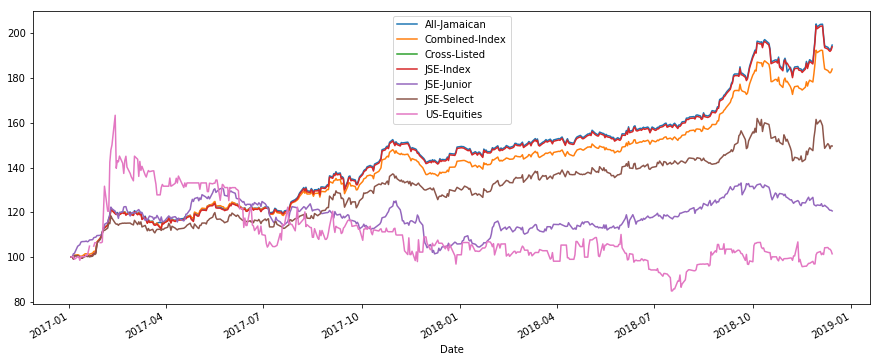

In [40]:
indicesplot = ((df_ind_data / df_ind_data.iloc[0]) * 100)
indicesplot.sort_index(axis=0).head()
indicesplot.plot(figsize=(15, 6));
#plt.rcParams.update({'font.size': 12})
#(df_ind_data / df_ind_data.iloc[0] * 100).plot(figsize=(15, 6));
plt.show()


In [41]:
#indicies Annual Rate of Return
annual_ind_returns = ind_returns.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count())) 
#annual_ind_returns = ind_returns.mean() * ind_returns.count()
round(annual_ind_returns[:] * 100,5)

All-Jamaican      33.93157
Combined-Index    31.04762
Cross-Listed      -4.87890
JSE-Index         33.72640
JSE-Junior         9.53855
JSE-Select        20.51597
US-Equities        0.73739
dtype: float64

<h3> Analysis for Jamaia Stocks </h3>

In [79]:
# This is simple rate of returns 
#rate_return = (stkframe/stkframe.shift(1))-1
# same as 
#rate_return = stkframe.pct_change()

# This is simple rate of returns with dividends involved
#rate_return = ((stkframe+divframe)/stkframe.shift(1))-1

# This is rate of returns with log
rate_return_div = np.log((stkframe+divframe)/stkframe.shift(1))
rate_return = np.log(stkframe/stkframe.shift(1))

rate_return.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.011748,0.016261,0.000000,0.000000,0.080043,0.000000,0.000000,0.00000,-0.001814,-0.117783,...,0.027846,NaN,NaN,0.0,NaN,-0.038392,0.0,NaN,NaN,-0.098857
2017-01-05,-0.026329,-0.016261,0.000000,0.097126,-0.052103,0.000000,0.000000,0.00000,0.004228,0.000000,...,-0.054365,NaN,NaN,0.0,NaN,0.000000,0.0,NaN,NaN,-0.007656
2017-01-06,0.004188,0.008163,0.000000,0.000000,0.000000,0.066691,-0.003454,0.00000,0.003460,0.223144,...,0.026175,NaN,NaN,0.0,NaN,0.019380,0.0,NaN,NaN,0.006702
2017-01-09,-0.062829,-0.016394,0.127833,0.053697,0.000000,0.100867,0.037356,0.03095,-0.002255,0.000000,...,-0.000345,NaN,NaN,0.0,NaN,-0.021339,0.0,NaN,NaN,-0.026101


In [43]:
rate_return = rate_return.replace([np.inf, -np.inf], np.nan)
rate_return.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.011748,0.016261,0.000000,0.000000,0.080043,0.000000,0.000000,0.00000,-0.001814,-0.117783,...,0.027846,NaN,NaN,0.0,NaN,-0.038392,0.0,NaN,NaN,-0.098857
2017-01-05,-0.026329,-0.016261,0.000000,0.097126,-0.052103,0.000000,0.000000,0.00000,0.004228,0.000000,...,-0.054365,NaN,NaN,0.0,NaN,0.000000,0.0,NaN,NaN,-0.007656
2017-01-06,0.004188,0.008163,0.000000,0.000000,0.000000,0.066691,-0.003454,0.00000,0.003460,0.223144,...,0.026175,NaN,NaN,0.0,NaN,0.019380,0.0,NaN,NaN,0.006702
2017-01-09,-0.062829,-0.016394,0.127833,0.053697,0.000000,0.100867,0.037356,0.03095,-0.002255,0.000000,...,-0.000345,NaN,NaN,0.0,NaN,-0.021339,0.0,NaN,NaN,-0.026101


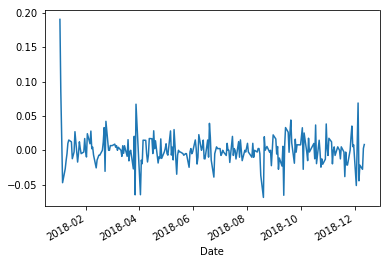

<Figure size 2400x2000 with 0 Axes>

In [44]:
#Sample of rate of return
rate_return['VMIL'].plot()
plt.figure(figsize=(30,25), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 10})
plt.show()

[]

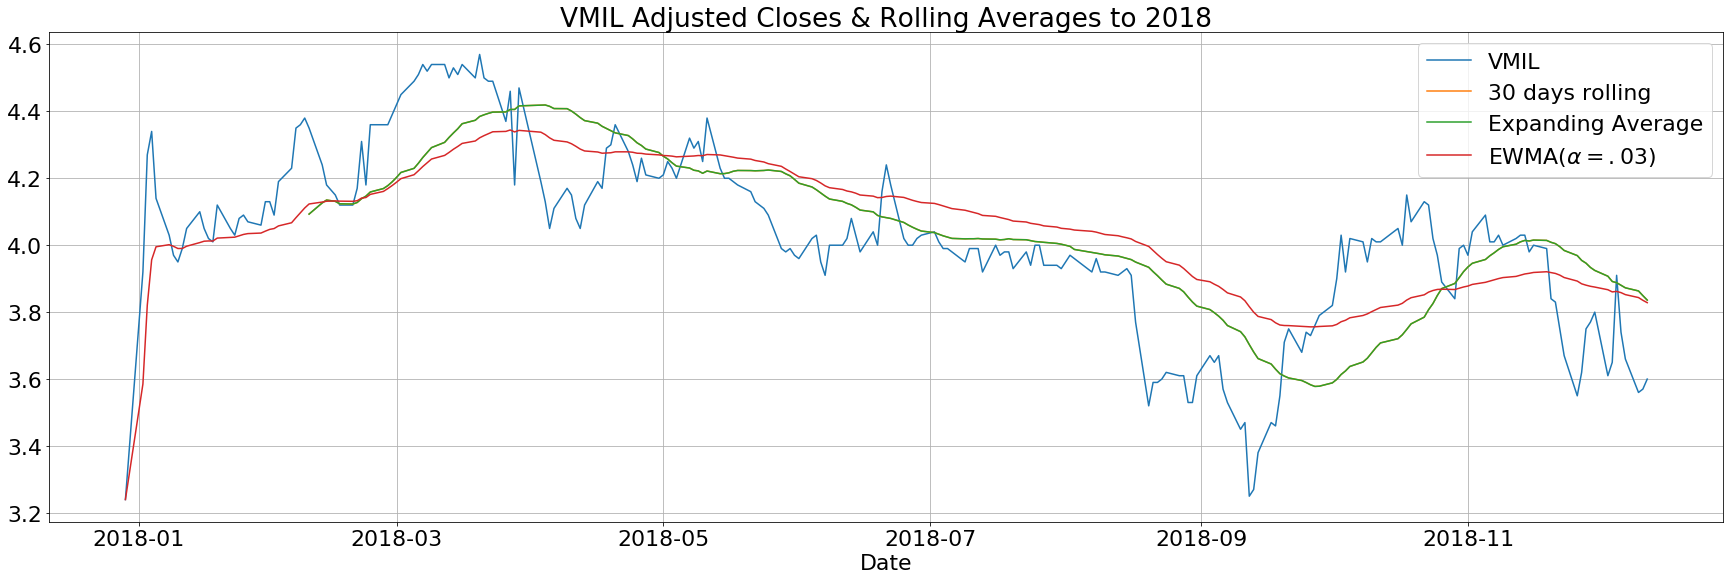

In [45]:

sym = 'VMIL'

df_closing = stkframe[sym]
df_30days = df_closing.rolling( 30 ).mean()
df_expand = df_closing.expanding().mean()
df_ewm = df_closing.ewm(alpha=0.03).mean()

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
fig.autofmt_xdate()
ax = fig.add_subplot(1,1,1)
ax.plot(df_closing.index, df_closing, label=sym)
ax.plot(df_30days.index, df_30days, label='30 days rolling') #simple moving average
ax.plot(df_expand.index, df_30days, label='Expanding Average')
ax.plot(df_ewm.index, df_ewm, label='EWMA($\\alpha=.03$)') # Exponentially weighted moving average

ax.grid()
ax.legend(loc=0)
ax.set_xlabel('Date')
plt.title(sym+' Adjusted Closes & Rolling Averages to 2018')
plt.plot()

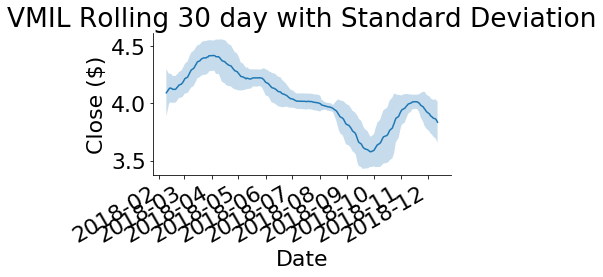

In [46]:
roll = df_closing.rolling( 30 )
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot()
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.title(sym+' Rolling 30 day with Standard Deviation')
plt.ylabel("Close ($)")
sns.despine()

In [47]:
rate_return[sym].dropna().head(),rate_return[sym].tail()

(Date
 2018-01-02    0.190518
 2018-01-03    0.085522
 2018-01-04    0.016261
 2018-01-05   -0.047179
 2018-01-08   -0.026929
 Name: VMIL, dtype: float64, Date
 2018-12-06   -0.044452
 2018-12-07   -0.021622
 2018-12-10   -0.027703
 2018-12-11    0.002805
 2018-12-12    0.008368
 Name: VMIL, dtype: float64)

In [48]:
stkframe[sym].dropna().head(),stkframe[sym].tail()

(Date
 2017-12-29    3.24
 2018-01-02    3.92
 2018-01-03    4.27
 2018-01-04    4.34
 2018-01-05    4.14
 Name: VMIL, dtype: float64, Date
 2018-12-06    3.74
 2018-12-07    3.66
 2018-12-10    3.56
 2018-12-11    3.57
 2018-12-12    3.60
 Name: VMIL, dtype: float64)

In [90]:

#Calculate the Average Rate of Return

avg_returns = rate_return_div.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count()))

# Drop all records with no application
avg_returns = avg_returns.dropna()
# Drop all record with 0 as rate of return
#avg_returns = avg_returns.drop(avg_returns[avg_returns == 0].index)
round(avg_returns[avg_returns > 0].sort_values(),5)*100

1834          3.308
SSLVC         3.922
WISYNCO       5.179
SEP           5.901
MJE           6.715
DCOVE        10.436
LASF         13.073
VMIL         14.302
CCC          14.449
GENAC        15.156
CBNY         15.508
KEY          18.789
KPREIT       20.413
SJ           21.373
SGJ          21.378
ProvenJA     22.582
MDS          22.756
GK           22.876
FOSRICH      23.973
KLE          25.375
CPJ          25.516
CFF          25.749
JSE          26.775
MIL          34.034
EPLY         35.938
ELITE        36.116
JBG          38.754
ISP          43.835
JMMBGL       44.458
AFS          44.659
PJAM         46.831
NCBFG        51.008
JAMT         51.638
JP           52.415
MEEG         59.410
BRG          59.630
CAC          61.931
SVL          62.439
KW           63.663
KEX          64.388
SIL          65.524
JETCON       67.133
SALF         69.233
INDIES       72.594
CAR          87.897
BIL          90.272
MUSIC        97.898
PAL         103.045
BPOW        103.070
ECL         106.386


In [91]:
#find the stocks that have split
round(avg_returns[avg_returns <= 0].sort_values(),5)*100

EFRESH   -79.303
GWEST    -66.905
SCIJMD   -48.743
LASD     -29.638
LASM     -21.371
HONBUN   -19.133
SCIJA    -18.349
PJX      -17.898
KREMI    -16.840
SML      -16.359
AMG      -13.932
RJR      -13.381
138SL    -13.102
CHL       -8.866
PTL       -8.417
XFUND     -6.873
PURITY    -5.498
SRA       -5.016
ROC       -3.994
TTECH     -0.755
dtype: float64

<h3> Calculate Stock Return Risk (Standard Deviation) </h3>

In [83]:
stk_std_risk = rate_return.apply(lambda x: (x.std()* 250 ** 0.5 ) if  x.count() > 250 else (x.std() * x.count() ** 0.5))
round(stk_std_risk.sort_values(),5) * 100

SRA          15.132
SCIJA        18.349
ProvenJA     19.975
GK           25.301
MJE          27.214
NCBFG        27.365
138SL        32.944
SSLVC        33.633
CAR          34.102
WISYNCO      34.636
SJ           35.067
SML          35.994
VMIL         36.385
CHL          39.084
PJAM         40.610
SCIJMD       40.646
SGJ          43.297
JBG          45.264
ROC          46.992
INDIES       48.247
JMMBGL       48.301
KW           49.730
XFUND        49.981
EFRESH       50.462
PJX          51.003
DCOVE        53.257
KPREIT       53.725
LASM         54.391
LASD         54.492
AFS          55.075
             ...   
GWEST        62.615
GENAC        63.238
RJR          63.809
LASF         63.866
1834         65.270
JAMT         65.385
JSE          65.867
BRG          68.594
SALF         70.880
FOSRICH      70.947
TTECH        70.962
HONBUN       71.491
SIL          71.666
EPLY         73.699
MDS          76.163
KLE          76.577
BPOW         77.406
PTL          77.449
MIL          78.525


<h3> Stock Correlation </h3>

In [52]:
#Variance of two stocks
rate_return[['VMIL','CAR']].var() 

VMIL    0.000547
CAR     0.001671
dtype: float64

In [53]:
#Annualize the Variance
rate_return[['VMIL','CAR']].var() * 250

VMIL    0.136686
CAR     0.417695
dtype: float64

In [54]:
#Covariance of two stock
rate_return[['VMIL','CAR']].cov() 

,VMIL,CAR
VMIL,0.000547,0.000013
CAR,0.000013,0.001671


In [55]:
#Annualize covariance of two stock
rate_return[['VMIL','CAR']].cov() * 250

,VMIL,CAR
VMIL,0.136686,0.003335
CAR,0.003335,0.417695


In [56]:
#Correlation of returns of two stock
rate_return[['VMIL','CAR']].corr()

,VMIL,CAR
VMIL,1.000000,0.027573
CAR,0.027573,1.000000


<h2> Sharpe Ratio </h2>

In [92]:
bondrate = 0.05
sharpe = (avg_returns - bondrate) / stk_std_risk
sharpe[sharpe > 0].sort_values() 

WISYNCO     0.005158
SEP         0.015421
MJE         0.063033
CBNY        0.086149
DCOVE       0.102064
LASF        0.126407
CCC         0.157509
GENAC       0.160604
KEY         0.175392
MDS         0.233130
VMIL        0.255654
KLE         0.266074
FOSRICH     0.267423
KPREIT      0.286882
CPJ         0.328274
JSE         0.330593
CFF         0.338372
MIL         0.369739
SGJ         0.378277
EPLY        0.419792
SJ          0.466891
ELITE       0.563011
ISP         0.631356
MEEG        0.643453
GK          0.706532
JAMT        0.713281
AFS         0.720096
JBG         0.745717
BRG         0.796434
JP          0.806779
JMMBGL      0.816925
SIL         0.844533
ProvenJA    0.880170
SALF        0.906225
CAC         0.964114
JETCON      1.020173
SVL         1.021728
PJAM        1.030056
SOS         1.033851
KEX         1.052811
ECL         1.096891
MUSIC       1.143062
PULS        1.169960
KW          1.179629
PAL         1.215965
BPOW        1.266960
INDIES      1.400981
BIL         1

In [93]:
sharpe[sharpe <= 0].sort_values() 

EFRESH   -1.670626
SCIJMD   -1.322229
SCIJA    -1.272497
GWEST    -1.148371
SRA      -0.661864
LASD     -0.635661
SML      -0.593398
138SL    -0.549471
LASM     -0.484832
PJX      -0.448962
CHL      -0.354765
HONBUN   -0.337573
AMG      -0.321077
RJR      -0.288060
KREMI    -0.256660
XFUND    -0.237542
ROC      -0.191393
PTL      -0.173238
PURITY   -0.124121
TTECH    -0.081103
SSLVC    -0.032050
1834     -0.025926
dtype: float64

<h2> Stock Regression </h2>

In [59]:
time = stkframe[sym].dropna().index.astype(int)/10000000000
#time = pd.to_timedelta(time.index.tolist()).dt.total_seconds().astype(int)
price = stkframe[sym].dropna().tolist()

In [60]:
time = np.reshape(time, (len(time), 1))
price = np.reshape(price, (len(price), 1))

In [61]:
time

Float64Index([[151450560.0], [151485120.0], [151493760.0], [151502400.0],
              [151511040.0], [151536960.0], [151545600.0], [151554240.0],
              [151562880.0], [151571520.0],
              ...
              [154344960.0], [154353600.0], [154379520.0], [154388160.0],
              [154396800.0], [154405440.0], [154414080.0], [154440000.0],
              [154448640.0], [154457280.0]],
             dtype='float64', name='Date', length=241)

In [62]:
time1 = sm.add_constant(time)
reg = sm.OLS(price, time1).fit()

In [63]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     149.5
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           5.07e-27
Time:                        19:28:41   Log-Likelihood:                 35.631
No. Observations:                 241   AIC:                            -67.26
Df Residuals:                     239   BIC:                            -60.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.0386      2.373     13.920      0.000      28.363      37.714
x1         -1.897e-07   1.55e-08    -12.227      0.000    -2.2e-07   -1.59e-07
==============================================================================
Omnibus:                       42.146   Durbin-Watson:                   0.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.050
Skew:                          -0.883   Prob(JB):                     9.25e-19
Kurtosis:                       5.271   Cond. No.                     2.69e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

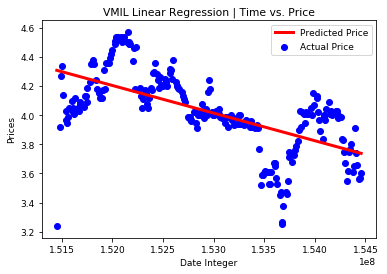

In [64]:
#Regression on Price vs Time
regressor = LinearRegression()
regressor.fit(time, price)
plt.rcParams.update({'font.size': 9})
plt.scatter(time,price, color='blue', label= 'Actual Price')
plt.plot(time, regressor.predict(time), color='red', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title(sym +' Linear Regression | Time vs. Price')
plt.legend()
plt.xlabel('Date Integer')
plt.ylabel('Prices')
plt.show()

<h3> Prediction Model Stock</h3>

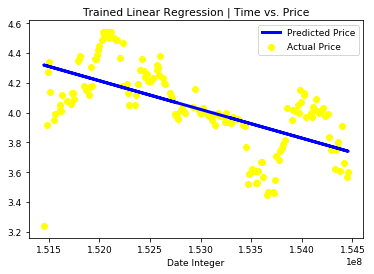

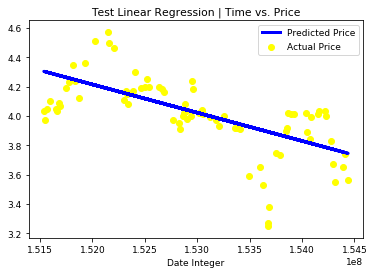

In [65]:
#Splitting the dataset into the Training set and Test set
xtrain, xtest, ytrain, ytest = train_test_split(time, price, test_size=0.33, random_state=42)

xtrain = np.reshape(xtrain, (len(xtrain), 1))
ytrain = np.reshape(ytrain, (len(ytrain), 1))

xtest = np.reshape(xtest, (len(xtest), 1))
ytest = np.reshape(ytest, (len(ytest), 1))

regressor.fit(xtrain, ytrain)
plt.rcParams.update({'font.size': 9})

#Train Set Graph
plt.scatter(xtrain, ytrain, color='yellow', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtrain, regressor.predict(xtrain), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Trained Linear Regression | Time vs. Price')
plt.legend()
plt.xlabel('Date Integer')
plt.show()

#Test Set Graph
plt.scatter(xtest, ytest, color='yellow', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtest, regressor.predict(xtest), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Test Linear Regression | Time vs. Price')
plt.legend()
plt.xlabel('Date Integer')
plt.show()

<h2> Calculating Portfolio </h2>

In [66]:
# Find Stock that has the same about of trade days
value = stkframe.count(axis=0)
value = value.index[stkframe.count(axis=0) == stkframe['CAR'].count()]
value

Index(['CCC', '1834', 'AFS', 'AMG', 'BIL', 'BPOW', 'BRG', 'CAC', 'CAR', 'CBNY',
       '138SL', 'CFF', 'CHL', 'CPJ', 'DCOVE', 'DTL', 'EPLY', 'GENAC', 'GK',
       'HONBUN', 'ISP', 'JAMT', 'JBG', 'JETCON', 'JMMBGL', 'JP', 'JSE', 'KEX',
       'KEY', 'KLE', 'KPREIT', 'KREMI', 'KW', 'LASD', 'LASF', 'LASM', 'MDS',
       'MIL', 'PAL', 'PJAM', 'PJX', 'PTL', 'PULS', 'PURITY', 'ProvenJA', 'RJR',
       'ROC', 'SALF', 'SEP', 'SGJ', 'SIL', 'SJ', 'SRA', 'SVL', 'TTECH',
       'XFUND'],
      dtype='object')

In [67]:
#Create Porfolio by randomly selecting 6 Stocks
selectStock = []
for i in range(0,6):
    rand_indx = np.random.randint(len(value))
    selectStock.append(value[rand_indx])

selectStock

['JMMBGL', 'JSE', 'GK', 'BPOW', 'EPLY', 'JSE']

In [68]:
rate_return[selectStock].describe()

,JMMBGL,JSE,GK,BPOW,EPLY,JSE
count,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,0.001778,0.001071,0.000915,0.004123,0.001438,0.001071
std,0.030578,0.041651,0.015999,0.071086,0.046643,0.041651
min,-0.198338,-0.261032,-0.080923,-0.278713,-0.181322,-0.261032
25%,-0.011063,-0.009053,-0.007752,0.000000,0.000000,-0.009053
50%,0.000604,0.000000,0.001190,0.000000,0.000000,0.000000
75%,0.014162,0.008736,0.008524,0.000000,0.000000,0.008736
max,0.187460,0.269815,0.081821,1.140285,0.723300,0.269815


C:\Users\Romayne\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


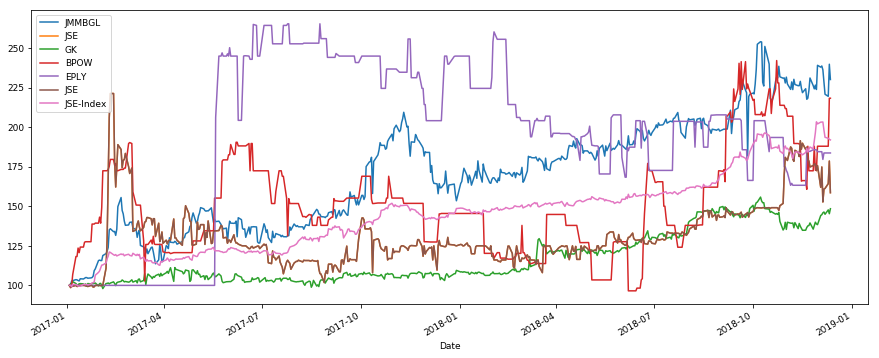

In [69]:
plt.rcParams.update({'font.size': 9})
portfolio_compare = pd.DataFrame
portfolio_compare = stkframe[selectStock]
portfolio_compare['JSE-Index'] = df_ind_data['JSE-Index']
(portfolio_compare / portfolio_compare.iloc[0] * 100).plot(figsize = (15, 6));
plt.show()
#df_ind_data['JSE-Index']
#portfolio_compare[selectStock].tail()

<h3> Calculate Portfolio Rate of Return </h3>

In [70]:
#Equally weighted Portfolio
weights = np.array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [71]:
pfolio_rate_return = str(round(np.dot(avg_returns[selectStock], weights),5) * 100) + "%"
'Returns on Porfolio :' + pfolio_rate_return 

'Returns on Porfolio :43.324%'

<h3> Calculate Portfolio Risk </h3>

In [72]:
# Calculate the covariance of the total portfolio
portfolio_var = np.dot(weights.T, np.dot(rate_return[selectStock].cov() * 250, weights))
'Variance :' + str(round(portfolio_var,5)*100) + '%'

'Variance :11.35%'

In [73]:
#Portfolio Volatilty
portfolio_vol = np.dot(weights.T, np.dot(rate_return[selectStock].cov() * 250, weights)) ** 0.5
'Volitility :' + str(round(portfolio_vol, 3)*100) + '%' 

'Volitility :33.7%'

<h3> Markowitz Portfolio effeciency Frontier </h3>

In [74]:
(rate_return[selectStock].mean() * 250)*100,rate_return[selectStock].cov() * 250,rate_return[selectStock].corr()

(JMMBGL     44.458175
 JSE        26.775126
 GK         22.875961
 BPOW      103.070242
 EPLY       35.938335
 JSE        26.775126
 dtype: float64,
           JMMBGL       JSE        GK      BPOW      EPLY       JSE
 JMMBGL  0.233759  0.047803  0.004672  0.016450 -0.000789  0.047803
 JSE     0.047803  0.433707 -0.001918  0.024668 -0.006897  0.433707
 GK      0.004672 -0.001918  0.063992 -0.013418 -0.005877 -0.001918
 BPOW    0.016450  0.024668 -0.013418  1.263302 -0.006106  0.024668
 EPLY   -0.000789 -0.006897 -0.005877 -0.006106  0.543892 -0.006897
 JSE     0.047803  0.433707 -0.001918  0.024668 -0.006897  0.433707,
           JMMBGL       JSE        GK      BPOW      EPLY       JSE
 JMMBGL  1.000000  0.150132  0.038203  0.030272 -0.002213  0.150132
 JSE     0.150132  1.000000 -0.011512  0.033325 -0.014201  1.000000
 GK      0.038203 -0.011512  1.000000 -0.047192 -0.031500 -0.011512
 BPOW    0.030272  0.033325 -0.047192  1.000000 -0.007367  0.033325
 EPLY   -0.002213 -0.014201 -0.031

In [75]:
frontier_pfolio_return = []
frontier_pfolio_vol = []
frontier_pfolio_weight = []
for x in range(0, 50000):
    ef_weights = np.random.random(len(selectStock))
    ef_weights /= np.sum(ef_weights)
    frontier_pfolio_return.append(np.dot(avg_returns[selectStock]*100, ef_weights))
    frontier_pfolio_vol.append(np.sqrt(np.dot(ef_weights.T, np.dot(rate_return[selectStock].cov() * 250, ef_weights)))*100)
    frontier_pfolio_weight.append(ef_weights)
    
frontier_pfolio_return = np.array(frontier_pfolio_return)
frontier_pfolio_vol = np.array(frontier_pfolio_vol)
frontier_pfolio_weight = np.array(frontier_pfolio_weight)

frontier_pfolio_return[:5],frontier_pfolio_vol[:5]

(array([43.82741241, 60.95111034, 47.46593594, 27.70445098, 48.88316044]),
 array([32.66482637, 57.58205293, 40.27986941, 33.6648158 , 39.70943823]))

In [76]:
frontier_pfolio_frame = pd.DataFrame({'Return':frontier_pfolio_return,'Volitile':frontier_pfolio_vol})

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selectStock):
    frontier_pfolio_frame[symbol+' weight'] = [weight[counter] for weight in frontier_pfolio_weight]

frontier_pfolio_frame=frontier_pfolio_frame.sort_values(by=['Volitile'])
frontier_pfolio_frame.head()

,Return,Volitile,JMMBGL weight,JSE weight,GK weight,BPOW weight,EPLY weight
5056,32.485945,20.863989,0.182385,0.076334,0.563233,0.052085,0.077269
23082,28.494253,20.917629,0.116427,0.010629,0.621019,0.014207,0.108896
11584,30.844628,20.963194,0.098147,0.079721,0.600955,0.045323,0.133059
44524,28.831469,21.134452,0.084187,0.074440,0.634679,0.022507,0.144627
18680,32.798581,21.169524,0.196974,0.029355,0.516975,0.045688,0.116810


In [77]:
frontier_pfolio_frame.tail()

,Return,Volitile,JMMBGL weight,JSE weight,GK weight,BPOW weight,EPLY weight
35590,72.748336,72.140977,0.006711,0.113689,0.004238,0.598014,0.026796
9325,76.486304,73.476371,0.010160,0.003725,0.170011,0.648623,0.077227
13285,78.070561,74.475268,0.016903,0.018771,0.041149,0.646328,0.201382
24267,79.285383,75.119623,0.143928,0.100261,0.086766,0.658525,0.006682
34785,80.008205,75.274446,0.170754,0.013595,0.083200,0.660665,0.014463


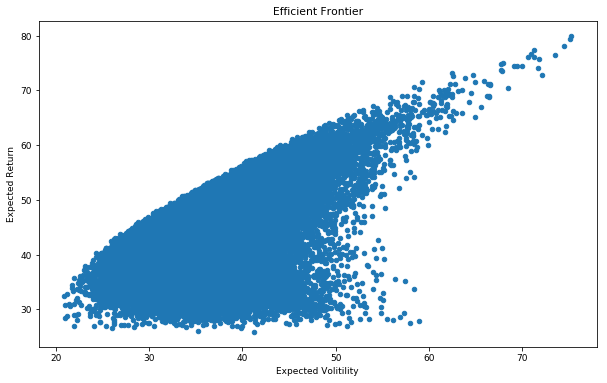

In [78]:
frontier_pfolio_frame.plot(x='Volitile',y='Return',kind='scatter',figsize=(10,6));
plt.xlabel('Expected Volitility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()